# Explore here

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import os

In [39]:
# Cargar conjunto de datos
url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"
df = pd.read_csv(url)
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


## Paso 2: Construye y analiza la serie temporal

In [40]:
df.shape

(366, 2)

In [41]:
# Ver el tipo de dato
df.dtypes

date      object
sales    float64
dtype: object

In [42]:
# Verificar si hay valores faltantes
df.isna().mean()*100

date     0.0
sales    0.0
dtype: float64

In [43]:
# Verificar si hay valores duplicados
df.duplicated().sum()

np.int64(0)

In [44]:
# Ver valores unicos
df.nunique()

date     366
sales    366
dtype: int64

Convertiré la columna date al formato de fecha y eliminaré la hora, minutos y segundos. Como solo hay una observación por día, creo que la información de la hora no aporta valor.

In [45]:
# Convertir la columna date a formato fecha y quitar la hora
df['date'] = pd.to_datetime(df['date'])       
df['date'] = df['date'].dt.normalize()        # Quita la hora, deja 00:00:00
df.dtypes

date     datetime64[ns]
sales           float64
dtype: object

In [46]:
# Convertir la columna date en el indice del DataFrame
df.set_index('date', inplace=True)

In [47]:
df.head()

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633


In [48]:
# Ver na fecha minima
df.index.min()

Timestamp('2022-09-03 00:00:00')

In [49]:
# Ver la fecha maxima
df.index.max()

Timestamp('2023-09-03 00:00:00')

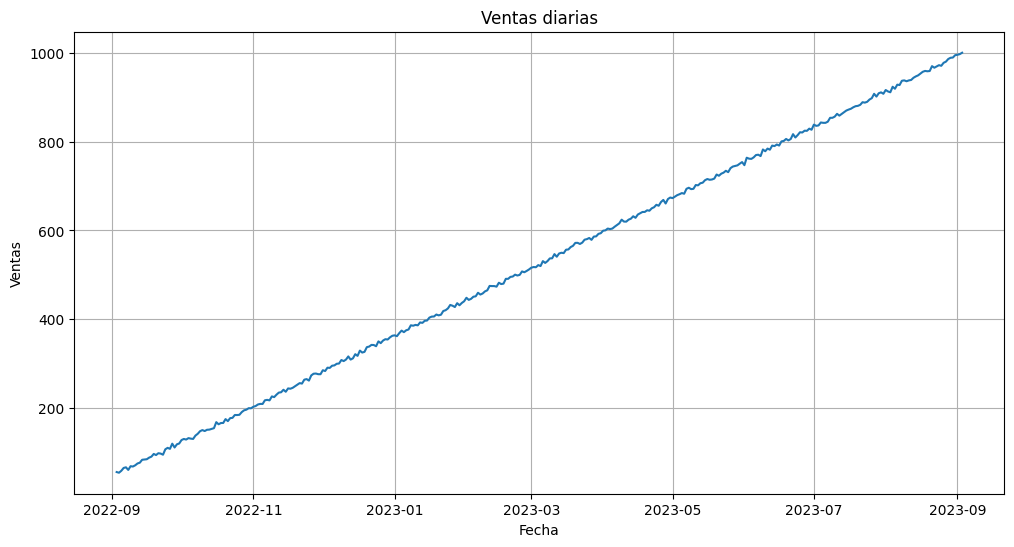

In [50]:
# Ver si hay tendencias, estacionalidad o valores extraños
plt.figure(figsize=(12, 6))
plt.plot(df['sales'])
plt.title('Ventas diarias')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.grid(True)
plt.show()

In [51]:
# Aplicar la prueba de Dickey-Fuller aumentada (ADF) para comprobar si serie es estacionaria
resultado = adfuller(df['sales'])
print(f'p-value: {resultado[1]}')

p-value: 0.9861899815311064


### Respuestas:

**¿Cuál es el tensor de la serie temporal?**

El dataset tiene 366 filas consecutivas con fechas distintas, eso indica que el tensor es diario.

**¿Cuál es la tendencia?**

La tendencia es creciente y constante a lo largo del tiempo.

**¿Es estacionaria?**

El p-value=0.98 indica que no es estacionaria. 

**¿Existe variabilidad o presencia de ruido?**

Sí, hay algo de variabilidad (ruido), pero no es muy fuerte. Las ventas no son completamente lineales y hay pequeñas variaciones día a día.

## Paso 3: Entrena un ARIMA

In [52]:
# Dividir los datos de entrenamiento y prueba
df_train = df.iloc[:300]['sales']
df_test = df.iloc[300:]['sales']

In [53]:
df_train.tail()

date
2023-06-25    821.218893
2023-06-26    820.704134
2023-06-27    824.762560
2023-06-28    824.418091
2023-06-29    829.329346
Name: sales, dtype: float64

In [54]:
df_test.head()

date
2023-06-30    826.902337
2023-07-01    838.399050
2023-07-02    835.672905
2023-07-03    836.589602
2023-07-04    843.232026
Name: sales, dtype: float64

In [55]:
# Comprobar estacionariedad
resultado = adfuller(df_train)
print(f'p-value: {resultado[1]}')

p-value: 0.9839380156744093


In [56]:
# Aplica la diferenciación al conjunto de entrenamiento para hacerla estacionaria y identificar el valor del d
df_train_diff = df_train.diff().dropna()

In [57]:
# Aplicar la prueba ADF sobre la serie diferenciada
result_diff = adfuller(df_train_diff)
print(f'p-value después de diferenciar: {result_diff[1]}')

p-value después de diferenciar: 3.0895585393046104e-24


Para identificar el valor de d, apliqué la prueba ADF sobre el conjunto de entrenamiento. Como el p-valor fue mayor a 0.05, realicé una primera diferenciación, tras la cual el p-valor cayó por debajo de 0.05. Esto indica que una sola diferenciación es suficiente para hacer la serie estacionaria, por lo que seleccioné d = 1.

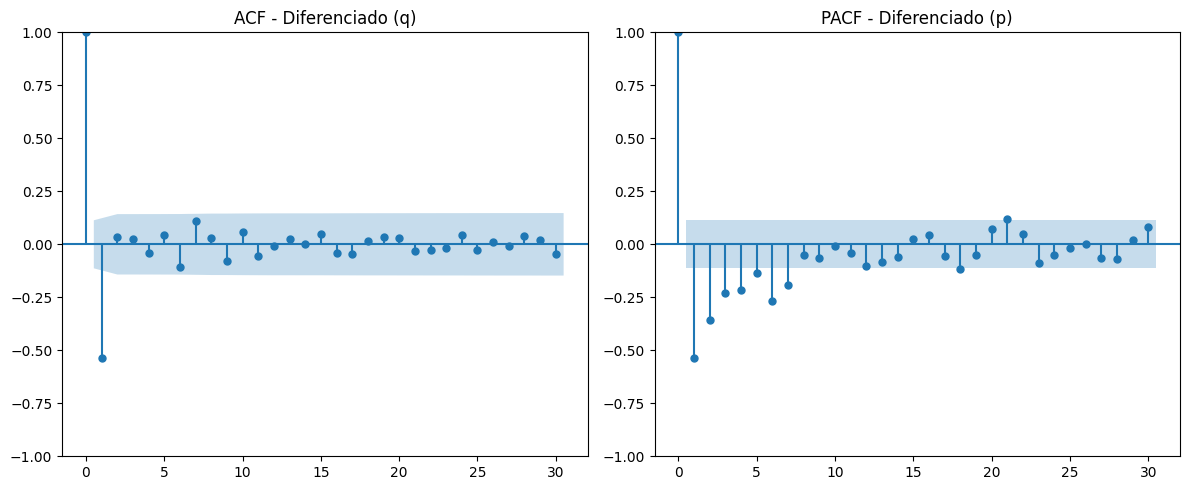

In [58]:
# Encontrar los parámetros p y q
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plot_acf(df_train_diff, ax=plt.gca(), lags=30)
plt.title('ACF - Diferenciado (q)')

plt.subplot(1,2,2)
plot_pacf(df_train_diff, ax=plt.gca(), lags=30)
plt.title('PACF - Diferenciado (p)')

plt.tight_layout()
plt.show()


Para encontrar los valores de p y q del modelo ARIMA, utilicé los gráficos ACF y PACF después de hacer la diferenciación.

En el gráfico PACF, vi que las barras se mantenían fuera del intervalo de confianza hasta el lag 8, así que decidí usar p = 8.

En el gráfico ACF, las barras significativas llegaban solo hasta el lag 2, por lo que seleccioné q = 2.

In [59]:
# Entrenar el modelo ARIMA
model = ARIMA(df_train, order=(8, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  300
Model:                 ARIMA(8, 1, 2)   Log Likelihood                -763.493
Date:                Wed, 02 Jul 2025   AIC                           1548.985
Time:                        12:48:07   BIC                           1589.690
Sample:                    09-03-2022   HQIC                          1565.277
                         - 06-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6887      0.205     -3.354      0.001      -1.091      -0.286
ar.L2          0.1832      0.076      2.403      0.016       0.034       0.333
ar.L3          0.2543      0.081      3.154      0.0

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Paso 4: Predice con el conjunto de test

In [60]:
# Definir el rango para predecir
start = df_test.index[0]
end = df_test.index[-1]

# Hacer la predicción
predictions = model_fit.predict(start=start, end=end, typ='levels')  # 'levels' predice en escala original

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


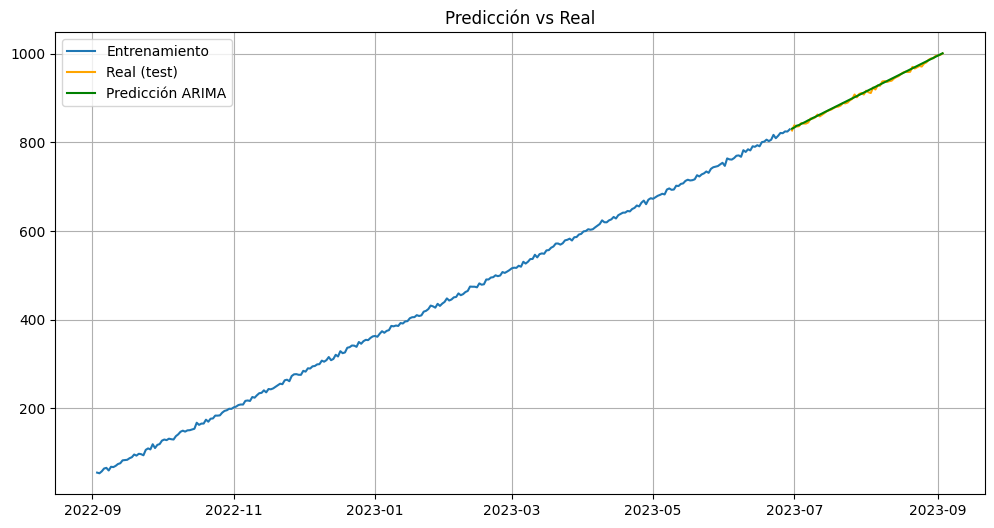

In [61]:
# Comparar con los valores reales
plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train, label='Entrenamiento')
plt.plot(df_test.index, df_test, label='Real (test)', color='orange')
plt.plot(predictions.index, predictions, label='Predicción ARIMA', color='green')
plt.title('Predicción vs Real')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
# Medir el rendimiento
mae = mean_absolute_error(df_test, predictions)
rmse = np.sqrt(mean_squared_error(df_test, predictions))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 2.50
RMSE: 3.03


**Conclusión:** El modelo ARIMA hizo predicciones bastante ajustadas, con un error medio de unas 2.5 unidades. Como las ventas están alrededor de 50-70, ese error es pequeño y el modelo funciona bien para anticipar las ventas y planificar el nuevo almacén.

## Paso 5: Guarda el modelo

In [63]:
# Crea la carpeta
if not os.path.exists('models'):
    os.makedirs('models')

# Guardar el modelo
joblib.dump(model_fit, 'models/arima_model.pkl')

['models/arima_model.pkl']